# 1.Perkenalan  
---
* Nama : Stanislaus Kanopi Johan Trielianto
* Batch  : FTDS -HCK -10
* Latar masalah : Prediksi jenis mobil melalui pengaplikasian machine learning merupakan bidang yang tengah berkembang pesat. Dalam industri yang terus berkembang, aplikasi ini menjadi sangat relevan, terutama dengan adopsi teknologi self-driving car dan sistem tilang otomatis di jalan. Namun, meskipun aplikasi ini telah menjadi semakin umum, masih banyak hal yang dapat dipelajari dari proyek ini, mulai dari penerapan Convolutional Neural Network (CNN) yang sederhana hingga penerapan praktisnya dalam kehidupan sehari-hari.

# 2.Import Libraries
---

In [26]:
# import libraries yang dibutuhkan
from google.colab import files
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Rescaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [27]:
pip install opendatasets


In [28]:
!pip install -q kaggle


In [29]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
total 0
cat: /root/.kaggle/kaggle.json: No such file or directory


# 3.Data Loading
---
  

In [30]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/marquis03/vehicle-classification")

Skipping, found downloaded files in "./vehicle-classification" (use force=True to force download)


In [31]:
bus_files = glob.glob('vehicle-classification/train/bus/*')
family_sedan_files= glob.glob('vehicle-classification/train/family sedan/*')
fire_engine_files= glob.glob('vehicle-classification/train/fire engine/*')
heavy_truck_files = glob.glob('vehicle-classification/train/heavy truck/*')
jeep_files = glob.glob('vehicle-classification/train/jeep/*')
minibus_files=glob.glob('vehicle-classification/train/minibus/*')
racing_car_files=glob.glob('vehicle-classification/train/racing car/*')
SUV_files =glob.glob('vehicle-classification/train/SUV/*')
taxi_files =glob.glob('vehicle-classification/train/taxi/*')
truck_files=glob.glob('vehicle-classification/train/truck/*')


>Mengubah data yang didapat menjadi bentuk pandas

In [32]:



# Combine all the files
imgs = bus_files + family_sedan_files + fire_engine_files + heavy_truck_files + jeep_files + minibus_files + racing_car_files + SUV_files + taxi_files + truck_files

# Define your labels
labels = ['bus' for _ in range(len(bus_files))] + ['family sedan' for _ in range(len(family_sedan_files))] + ['fire engine' for _ in range(len(fire_engine_files))] + ['heavy truck' for _ in range(len(heavy_truck_files))] + ['jeep' for _ in range(len(jeep_files))] + ['minibus' for _ in range(len(minibus_files))] + ['racing car' for _ in range(len(racing_car_files))] + ['SUV' for _ in range(len(SUV_files))] + ['taxi' for _ in range(len(taxi_files))] + ['truck' for _ in range(len(truck_files))]

# Create DataFrame
data = pd.DataFrame({
    'images': imgs,
    'label': labels
})

# Shuffle DataFrame
data = data.sample(frac=1).reset_index(drop=True)


In [33]:
data

,images,label
0,vehicle-classification/train/minibus/9f867d129...,minibus
1,vehicle-classification/train/heavy truck/5a731...,heavy truck
2,vehicle-classification/train/SUV/b1af2fb4ec7b9...,SUV
3,vehicle-classification/train/SUV/59315355e9a94...,SUV
4,vehicle-classification/train/racing car/3018f1...,racing car
...,...,...
1395,vehicle-classification/train/minibus/ffe6a42fd...,minibus
1396,vehicle-classification/train/minibus/27de11869...,minibus
1397,vehicle-classification/train/family sedan/69ce...,family sedan
1398,vehicle-classification/train/bus/a2219fd1636ed...,bus


>Cek labeling dalam dataset yang disediakan

In [34]:
data['label'].value_counts()

minibus         140
heavy truck     140
SUV             140
racing car      140
taxi            140
fire engine     140
family sedan    140
bus             140
jeep            140
truck           140
Name: label, dtype: int64

Insight : Semua data sudah berdasarkan jumlah yang sama

# 4.Data

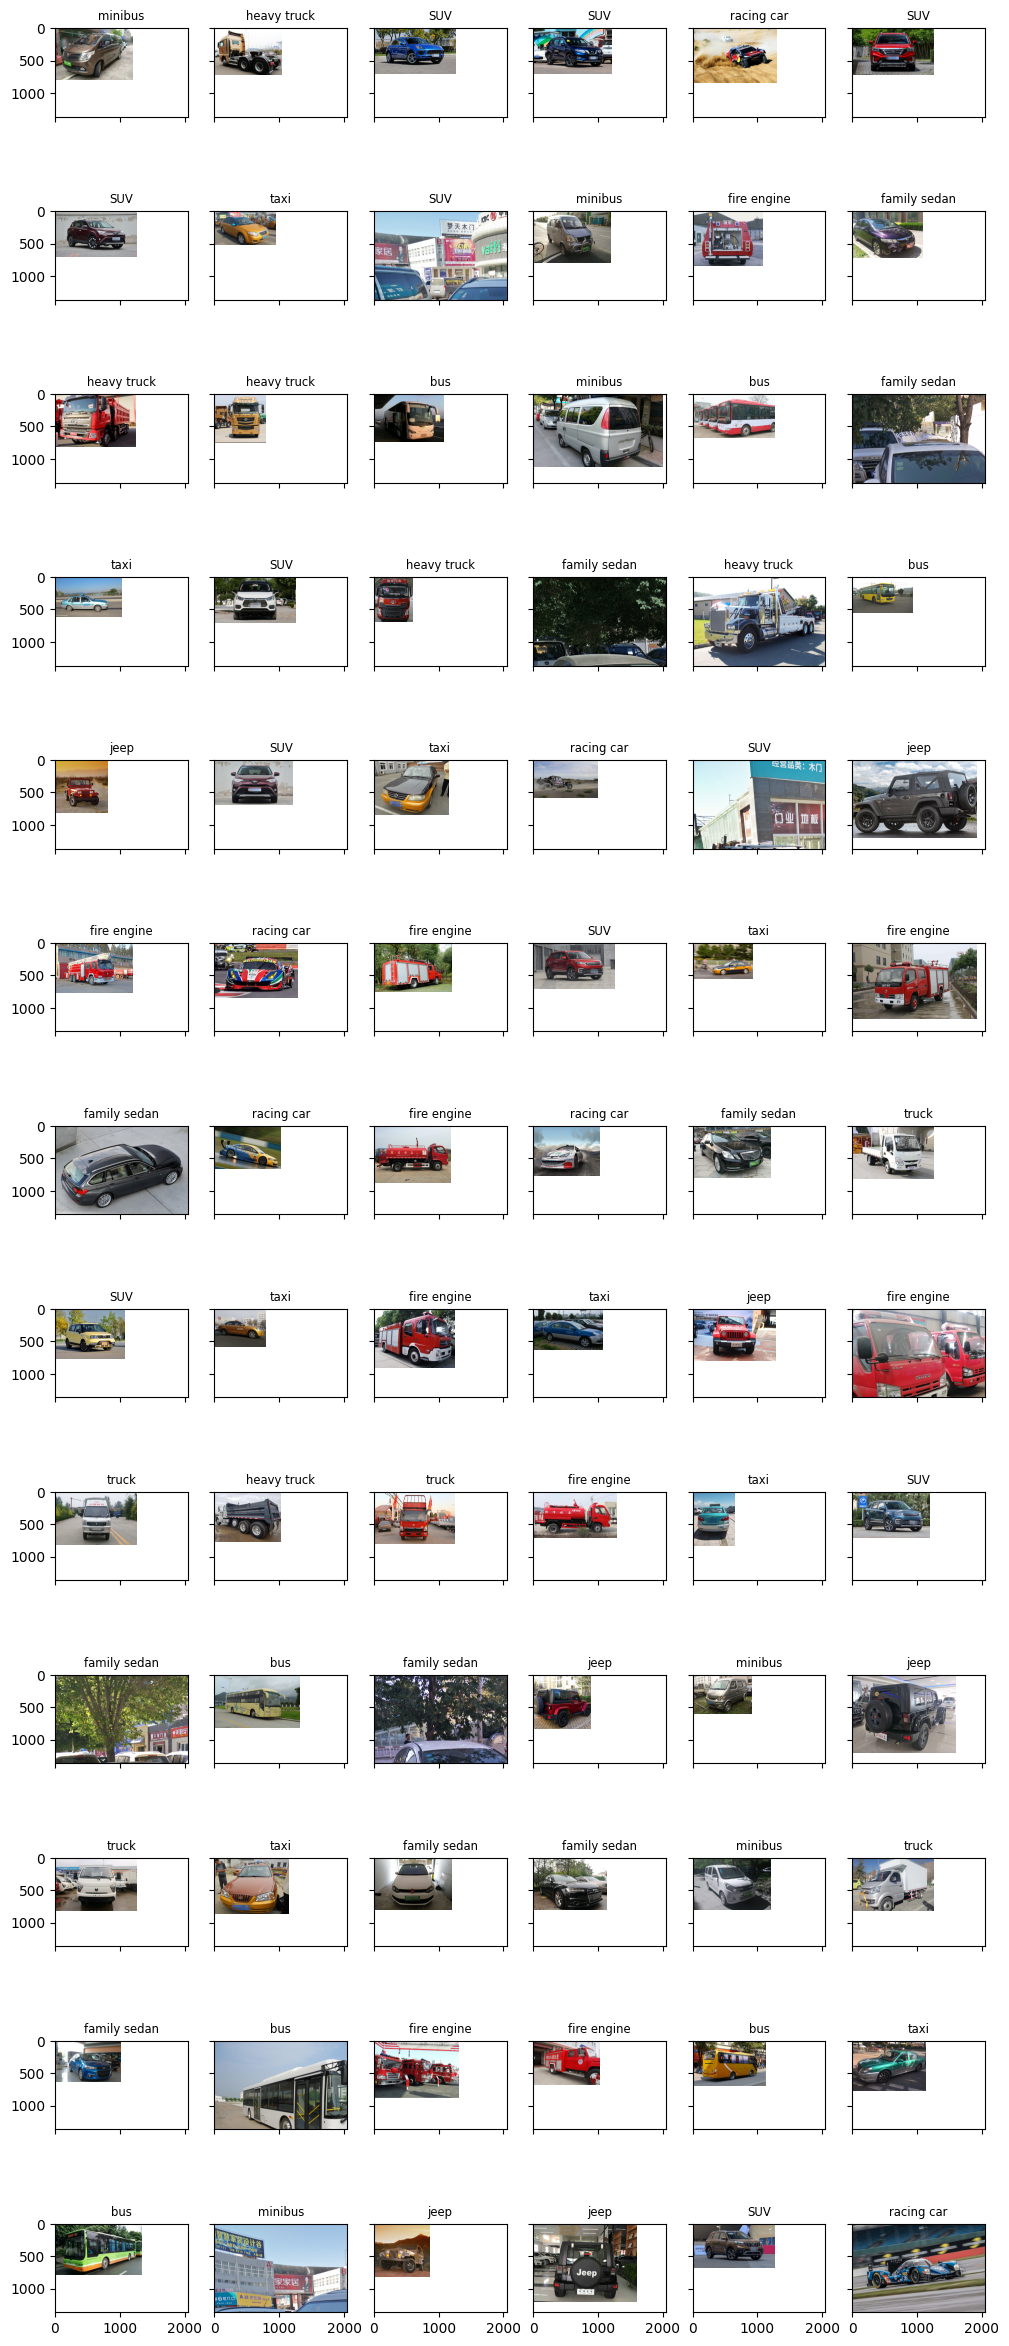

In [57]:
# Membuat visualisasi untuk setiap class
fig, axes = plt.subplots(13, 6, figsize=(12, 30), sharex=True, sharey=True)

for ax in axes.flat:
    ax.set_axis_off()

for ax, (index, row) in zip(axes.flat, data.iterrows()):
    image = plt.imread(f"{row['images']}")
    ax.imshow(image)
    ax.set_title(row['label'], fontsize='small')
    ax.axis('on')  # Menampilkan sumbu pada setiap subplot

fig.subplots_adjust(hspace=0.6)

plt.show()

Kita bisa melihat bahwa Hampir semua mobil mobil yang diberikan , rata rata dari tampak samping , jarang ada yang dari tampak depan , dan ada beberapa data yang tidak sempurna . Kita bisa melihat dal
am Jeep dan Truck banyak gambar yang hampir sama

#5. Feature Enginering and Data preprocessing


Data PReprocessing tidak ada yang banyak di rubah  .
Dikarenakan pada setiap gambar masih kurang stabil , tidak ada yang standar pengambilan gambar yang jelas ,makadari itu saya tidak mengaplikasikan zoom ,rotate ,ataupun image preprocessing yang lainya  , karena dikawatirkan akan merusak gambar lebih jauh ,hanya Rescale dan target size (150,150)

In [36]:
#Rescale data 1./255.
test_datagen = ImageDataGenerator(rescale=1./255.)
path  = "vehicle-classification/val/"
test = test_datagen.flow_from_directory(path,
	                                      target_size=(150,150),
	                                      class_mode='categorical',
  	                                    batch_size=126,
	                                      shuffle=False)

Found 200 images belonging to 10 classes.


>Pemisahan data berdasarkan train dan Val

In [37]:
imgen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2
                                                        ,rescale=1./255.)
path = "vehicle-classification/train/"
train = imgen.flow_from_directory(path,
                                  target_size=(150,150),
                                  class_mode='categorical',
                                  subset='training',shuffle=False)
val = imgen.flow_from_directory(path,
                                  target_size=(150,150),
                                  class_mode='categorical',
                                  subset='validation',shuffle=False)

Found 1120 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


In [38]:
print(train.class_indices)
print(val.class_indices)
print(test.class_indices)

{'SUV': 0, 'bus': 1, 'family sedan': 2, 'fire engine': 3, 'heavy truck': 4, 'jeep': 5, 'minibus': 6, 'racing car': 7, 'taxi': 8, 'truck': 9}
{'SUV': 0, 'bus': 1, 'family sedan': 2, 'fire engine': 3, 'heavy truck': 4, 'jeep': 5, 'minibus': 6, 'racing car': 7, 'taxi': 8, 'truck': 9}
{'SUV': 0, 'bus': 1, 'family sedan': 2, 'fire engine': 3, 'heavy truck': 4, 'jeep': 5, 'minibus': 6, 'racing car': 7, 'taxi': 8, 'truck': 9}


# 6.Model Definition

> Kita menyiapkan 2 model yang akan digunakan nantinya  . model pertama tanpa mengunakan flaten m

In [39]:
class_labels=list(train.class_indices.keys())

In [40]:
import tensorflow as tf

# Membuat model sequential
model = tf.keras.models.Sequential()

# Layer konvolusi pertama dengan 32 filter 3x3, fungsi aktivasi ReLU, dan input shape (150, 150, 3)
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Layer konvolusi kedua dengan 64 filter 3x3 dan fungsi aktivasi ReLU
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Layer konvolusi ketiga dengan 128 filter 3x3 dan fungsi aktivasi ReLU
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Global Average Pooling untuk meratakan output
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Layer dropout untuk mengurangi overfitting
model.add(tf.keras.layers.Dropout(0.5))

# Dense layer dengan 512 neuron dan fungsi aktivasi ReLU
model.add(tf.keras.layers.Dense(512, activation='relu'))

# Dense layer terakhir dengan 10 neuron (sesuai jumlah kelas) dan fungsi aktivasi softmax
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

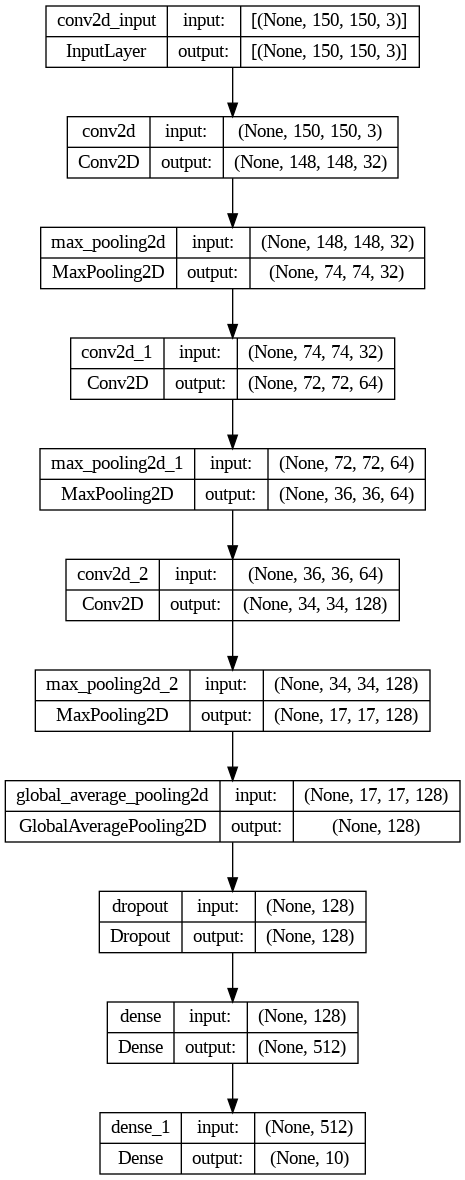

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

> Model ke dua dengan Flatten

In [48]:
import tensorflow as tf

# Membuat model sequential
model1 = tf.keras.models.Sequential()

# Layer konvolusi pertama dengan 32 filter 3x3, fungsi aktivasi ReLU, dan input shape (150, 150, 3)
model1.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Layer konvolusi kedua dengan 64 filter 3x3 dan fungsi aktivasi ReLU
model1.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Layer konvolusi ketiga dengan 128 filter 3x3 dan fungsi aktivasi ReLU
model1.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2, 2))  # Layer max pooling

# Flatten layer untuk meratakan output sebelum masuk ke layer Dense
model1.add(tf.keras.layers.Flatten())

# Layer dropout untuk mengurangi overfitting
model1.add(tf.keras.layers.Dropout(0.5))

# Dense layer dengan 512 neuron dan fungsi aktivasi ReLU
model1.add(tf.keras.layers.Dense(512, activation='relu'))

# Dense layer terakhir dengan 10 neuron (sesuai jumlah kelas) dan fungsi aktivasi softmax
model1.add(tf.keras.layers.Dense(10, activation='softmax'))


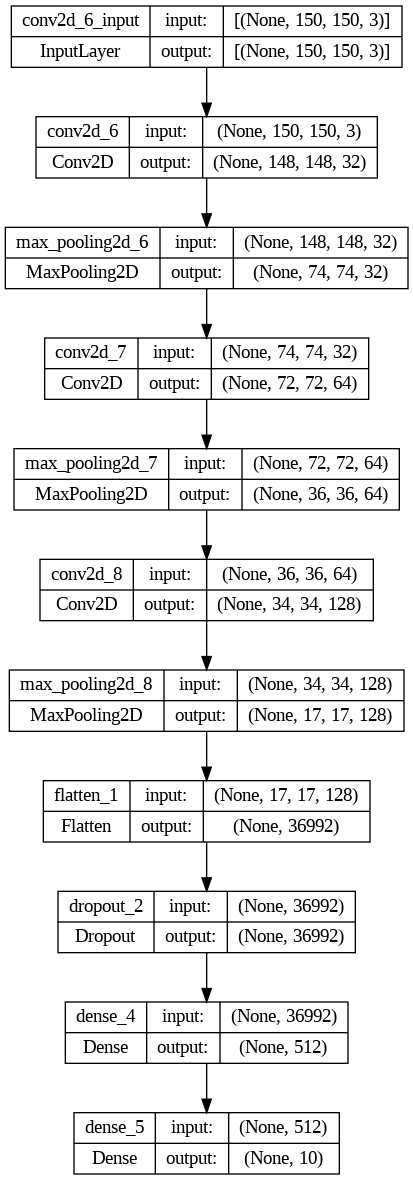

In [50]:
tf.keras.utils.plot_model(model1, show_shapes=True)

# 7.Model training  

In [44]:
# callbacks1= [
#     EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
#     ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
# ]

>Base model train

In [45]:
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(train, epochs=25,steps_per_epoch=35, validation_data = val, verbose = 1)

Epoch 1/25
35/35 [==============================] - 42s 926ms/step - loss: 2.3589 - accuracy: 0.0571 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/25
35/35 [==============================] - 21s 599ms/step - loss: 2.3050 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/25
35/35 [==============================] - 21s 601ms/step - loss: 2.3036 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/25
35/35 [==============================] - 20s 579ms/step - loss: 2.3035 - accuracy: 0.0848 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/25
35/35 [==============================] - 21s 604ms/step - loss: 2.3034 - accuracy: 0.0938 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/25
35/35 [==============================] - 20s 575ms/step - loss: 2.3035 - accuracy: 0.0554 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/25
35/35 [==============================] - 22s 630ms/step - loss: 2.3036 - accuracy: 0.0232 - val_loss: 2.3026 - val_accuracy: 0.1000

>Better model train

In [51]:
model1.compile(loss ='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history1 = model1.fit(train, epochs=100, steps_per_epoch=20, validation_data = val, verbose = 1)

Epoch 1/100
20/20 [==============================] - 17s 773ms/step - loss: 3.8084 - accuracy: 0.1484 - val_loss: 2.3020 - val_accuracy: 0.1786
Epoch 2/100
20/20 [==============================] - 14s 726ms/step - loss: 2.3161 - accuracy: 0.0547 - val_loss: 2.3021 - val_accuracy: 0.1107
Epoch 3/100
20/20 [==============================] - 14s 704ms/step - loss: 2.3110 - accuracy: 0.0859 - val_loss: 2.2976 - val_accuracy: 0.1536
Epoch 4/100
20/20 [==============================] - 14s 714ms/step - loss: 2.3063 - accuracy: 0.1094 - val_loss: 2.3018 - val_accuracy: 0.1000
Epoch 5/100
20/20 [==============================] - 13s 639ms/step - loss: 2.3041 - accuracy: 0.1516 - val_loss: 2.2993 - val_accuracy: 0.1000
Epoch 6/100
20/20 [==============================] - 14s 682ms/step - loss: 2.3015 - accuracy: 0.1187 - val_loss: 2.3009 - val_accuracy: 0.1071
Epoch 7/100
20/20 [==============================] - 14s 707ms/step - loss: 2.3464 - accuracy: 0.1578 - val_loss: 2.3258 - val_accuracy:

Disini saya menggunakan epoch 100 dengan tujuan mendapatkan nilai terbaik dari model , tapi  miss calculasi saya adalah , bahwa kemungkinan overfit sangat tinggi  ,dan terbukti , harusnya saya menggunakan callback  sehingga mendapatkan hasil/ model yang terbaik .

# 8. Model Evaluation

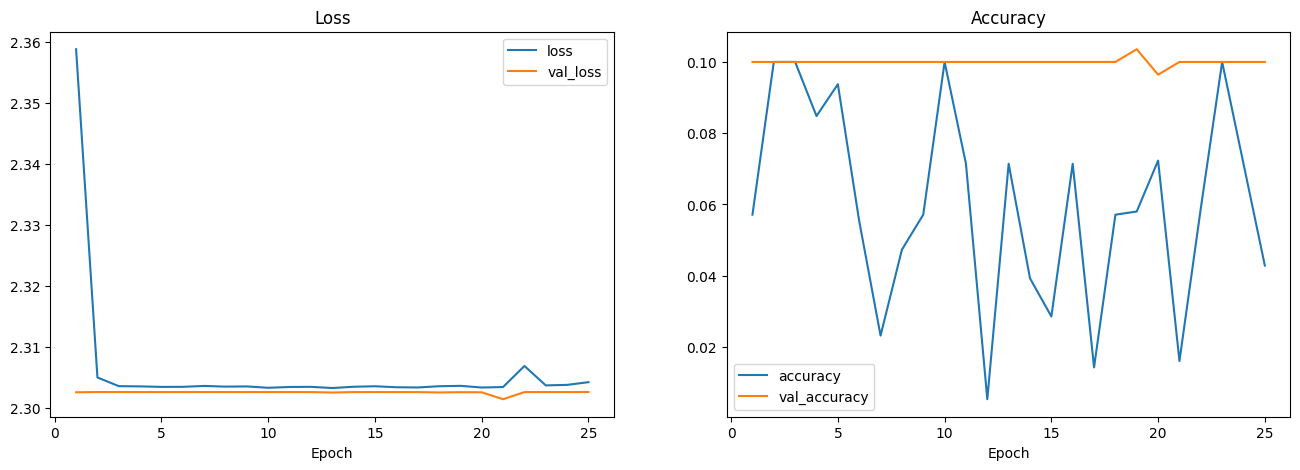

In [52]:
epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))

ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#x[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Dalam pembelajaran model  , Acuracy hanya stuck di 10 % , ada banyak kemungkinan ,salah satunya  karena data yang sedikit , ataupun Arsitek ann yang belum bisa mempelajari jenis gambar yang akan di pakai

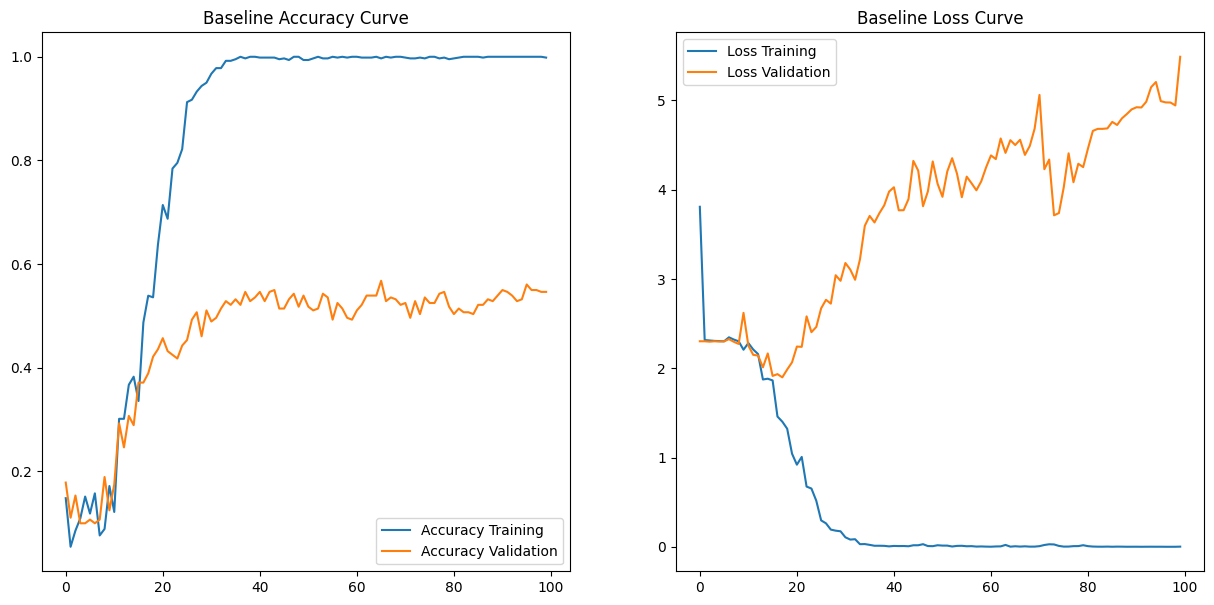

In [53]:
# evaluation model evaluation in plot shape
metrics = pd.DataFrame(history1.history) #create dataframe of learn model training

#accuracy plot
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(metrics.accuracy, label='Accuracy Training')
plt.plot(metrics.val_accuracy, label='Accuracy Validation')
plt.title('Baseline Accuracy Curve')
plt.legend()

#loss plot
plt.subplot(1, 2, 2)
plt.plot(metrics.loss, label='Loss Training')
plt.plot(metrics.val_loss, label='Loss Validation')
plt.title('Baseline Loss Curve')
plt.legend()
plt.show()


Insight: Setelah mencapai epoch ke-20, terlihat bahwa model mengalami stagnasi dalam pembelajaran dan mengalami exploding gradients, yang mengakibatkan performa model menjadi tidak stabil. Meskipun akurasi pada data pelatihan terus meningkat, akurasi pada data validasi tetap stagnan di sekitar 0.5, menunjukkan bahwa model tidak dapat melakukan generalisasi dengan baik pada data baru.

Kondisi ini mengindikasikan bahwa model mungkin mengalami overfitting, di mana ia secara efektif "menghafal" data pelatihan tanpa dapat menggeneralisasi pengetahuannya dengan baik pada data baru.

In [55]:
y_pred_test = model.predict(test)
y_pred_test = np.argmax(y_pred_test, axis=1)

announce = classification_report(test.labels,
                                    y_pred_test, labels = np.arange(33),
                                    target_names= list(test.class_indices.keys()))
print(announce)

2/2 [==============================] - 6s 2s/step
              precision    recall  f1-score   support

         SUV       0.00      0.00      0.00        20
         bus       0.00      0.00      0.00        20
family sedan       0.00      0.00      0.00        20
 fire engine       0.00      0.00      0.00        20
 heavy truck       0.00      0.00      0.00        20
        jeep       0.00      0.00      0.00        20
     minibus       0.00      0.00      0.00        20
  racing car       0.00      0.00      0.00        20
        taxi       0.10      1.00      0.18        20
       truck       0.00      0.00      0.00        20

   micro avg       0.10      0.10      0.10       200
   macro avg       0.00      0.03      0.01       200
weighted avg       0.01      0.10      0.02       200



In [ ]:
Pada model pertama kita bisa melihat bhwa model tidak bisa mempelajari selain taxi , dan semuanya akan dianggap taxi ,

In [54]:
y_pred_test = model1.predict(test)
y_pred_test = np.argmax(y_pred_test, axis=1)

announce = classification_report(test.labels,
                                    y_pred_test, labels = np.arange(33),
                                    target_names= list(test.class_indices.keys()))
print(announce)

2/2 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

         SUV       0.93      0.70      0.80        20
         bus       0.72      0.65      0.68        20
family sedan       0.43      0.65      0.52        20
 fire engine       0.50      0.40      0.44        20
 heavy truck       0.42      0.70      0.53        20
        jeep       0.48      0.55      0.51        20
     minibus       0.73      0.40      0.52        20
  racing car       0.60      0.15      0.24        20
        taxi       0.36      0.65      0.46        20
       truck       0.85      0.55      0.67        20

   micro avg       0.54      0.54      0.54       200
   macro avg       0.18      0.16      0.16       200
weighted avg       0.60      0.54      0.54       200



In [ ]:
Pada model kedua ,terlihat lebih baik ,meskipun jauh dari sempurna tapi memiliki performa JAUH lebih baik dari model pertama.

# 9. Model Save

In [56]:
model1.save("best_model.h5")

# Pengambilan Kesimpulan  
---  


Ada beberapa kesimpulan yang bisa disimpulkan
+ Data yang di dapat terlalu sedikit , dengan target multiclass  yang cukup banyak.  
+ Model selalu stuck saat training ,kemungkinan karena  data yang kurang memumpuni , dan kita menemukan bahwa data kurang consisten , ada beberapa foto/ gambar yang diambil dari samping , ada yang dari atas , dan depan , tidak adanya standar dalam pengambilan data .
+ Masih banyak hal yang harus dirubah dari model pertama , Kita bisa mengunakan transferlearning  untuk mendapatkan hasil lebih baik dari  yang kita punya .
+ Dari Akurasi (Micro Avg): 54% ,disimpulkan model mampu mengklasifikasikan dengan benar sekitar 54% dari total data.
+ Klasifikasi terbaik untuk kategori 'SUV' dengan precision 93%, menunjukkan bahwa dari semua yang diklasifikasikan sebagai 'SUV', sebagian besar benar-benar 'SUV'.
+ Klasifikasi terendah untuk kategori 'Taxi' dengan precision 36%, menunjukkan bahwa dari semua yang diklasifikasikan sebagai 'Taxi', hanya sebagian kecil yang benar-benar 'Taxi'.
+ Recall tertinggi untuk kategori 'SUV' dengan nilai 70%, menunjukkan bahwa dari semua data 'SUV', model berhasil mengidentifikasi 70% di antaranya.
Recall terendah untuk kategori 'Racing Car' dengan nilai 15%, menunjukkan bahwa dari semua data 'Racing Car', hanya 15% yang berhasil diidentifikasi oleh model.

+ Kesimpulannya, model ini mungkin memiliki performa yang baik untuk beberapa kategori (seperti 'SUV') tetapi perlu diperbaiki untuk kategori lainnya, terutama yang memiliki nilai precision, recall, dan F1-score rendah. Evaluasi lebih lanjut dan peningkatan model dapat dilakukan dengan mempertimbangkan teknik pengoptimalan, penyesuaian parameter model, atau menggunakan arsitektur yang lebih kompleks.